## MarketPlace Dataset curation

This notebook shows an experimental approach to dataset curation by using tools and libraries used in data science.

A number of python libraries, usually adopted in quantitative data analysis of large datasets, are used to explore the SSHOC MarketPlace dataset and try to discover inconsistencies and errors.


*Cesare Concordia, ISTI - CNR*

## Preamble

In [234]:
import ast
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# importing useful Python utility libraries we'll need
from collections import Counter, defaultdict
import itertools

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

### Function to download descriptions from the MarketPlace dataset using the API

In [116]:
def getMPDescriptions (url, pages):
    mdx = pd.Series(range(1, pages+1))
    df_desc = pd.DataFrame()
    for var in mdx:
        turl = url+str(var)+"&perpage=20"
        #print("url: "+ turl + ":",var)
        df_desc_par=pd.read_json(turl, orient='columns')
        df_desc=df_desc.append(df_desc_par, ignore_index=True)
        
    return (df_desc)

## Get the *property* values using API

The SSHOC Market Place API entry: 

https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/property-types

has been used to extract the list of properties used in the SSHOC Market Place. 

There are 28  property types in MP dataset. The following table shows code, labels and type

In [74]:
x = ('1','2')
df_dynammic_properties = pd.DataFrame()
for var in x:
    url = "https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/property-types?page="+str(var)+"&perpage=20"
    df_tool_par=pd.read_json(url, orient='columns')
    df_dynammic_properties=df_dynammic_properties.append(df_tool_par, ignore_index=True)

In [80]:
#properties are returned as JSON object, this code converts json in a dataframe
df_dypro_flat = pd.json_normalize(df_dynammic_properties['propertyTypes'])
df_dypro_flat_sub=df_dypro_flat[['code', 'label', 'type']]
df_dypro_flat_sub.sort_values('label').head(30)


,code,label,type
37,accesspolicy-url,Access Policy URL,string
1,activity,Activity,concept
29,authentication,Authentication,string
18,conference,Conference,string
14,cover-image,Cover Image,url
25,doi,DOI,string
30,geographical-availabilities,Geographical Availabilities,string
36,helpdesk-url,Helpdesk URL,string
20,issue,Issue,string
17,journal,Journal,string


#### Property Types with vocabularies

In [88]:
df_prop_data = pd.json_normalize(data = df_dynammic_properties['propertyTypes'], record_path='allowedVocabularies', meta_prefix='Property_type_', meta=['label'])
df_prop_data.sort_values('code').head(20)

,code,label,accessibleAt,Property_type_label
6,iana-mime-type,IANA mime/type,None,Object format
0,iso-639-3,ISO 639-3,None,Language
1,iso-639-3-v2,ISO 639-3 Sprachcodes,None,Language
2,nemo-activity-type,NeMO Concept Scheme,None,Activity
7,publication-type,The Bibliographic Ontology Concept Scheme,None,Publication type
4,tadirah-activity,TaDiRAH - Taxonomy of Digital Research Activities in the Humanities,None,Activity
5,tadirah-research-technique,TaDiRAH Research Technique,None,Technique
3,tadirah2,,None,Activity


## Get the the dataset descriptions and check them

## Tools and services

In [117]:
df_tool_all = pd.DataFrame()
df_tool_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools-services?page=", 81)
df_tool_all.index

RangeIndex(start=0, stop=1606, step=1)

Have a look at how data is structured

In [129]:
df_tool_flat = pd.json_normalize(df_tool_all['tools'])
df_tool_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   id                                       1606 non-null   int64 
 1   category                                 1606 non-null   object
 2   label                                    1606 non-null   object
 3   version                                  0 non-null      object
 4   persistentId                             1606 non-null   object
 5   description                              1606 non-null   object
 6   licenses                                 1606 non-null   object
 7   contributors                             1606 non-null   object
 8   properties                               1606 non-null   object
 9   accessibleAt                             1606 non-null   object
 10  sourceItemId                             1606 non-null   obj

Create a subset and work with it

In [131]:
df_tool_work=df_tool_flat[['id', 'category', 'label', 'licenses', 'contributors', 'accessibleAt', 'sourceItemId']]
df_tool_work.head()

,id,category,label,licenses,contributors,accessibleAt,sourceItemId
0,30509,tool-or-service,140kit,[],"[{'actor': {'id': 483, 'name': 'Ian Pearce, Devin Gaffney', 'externalIds': [], 'website': None, 'email': None, 'affiliations': []}, 'role': {'code': 'contributor', 'label': 'Contributor'}}]",[https://github.com/WebEcologyProject/140kit],937
1,28542,tool-or-service,3DF Zephyr - photogrammetry software - 3d models from photos,[],[],[https://www.3dflow.net/3df-zephyr-pro-3d-models-from-photos/],WQFP6XPS
2,11508,tool-or-service,3DHOP,[],[],[http://vcg.isti.cnr.it/3dhop/],SG86ZG5J
3,11419,tool-or-service,3DHOP: 3D Heritage Online Presenter,[],[],[https://github.com/cnr-isti-vclab/3DHOP],R379NADX
4,11507,tool-or-service,3DReshaper \| 3DReshaper,[],[],[https://www.3dreshaper.com/en/],PMES8DJW


Individuate duplicates based on values of property *label*

In [153]:
df_tool_work_duplicates=df_tool_work[df_tool_work.duplicated('label', keep=False)].sort_values('label')
df_tool_work_duplicates.sort_values('label').head()

,id,category,label,licenses,contributors,accessibleAt,sourceItemId
203,11448,tool-or-service,CloudCompare - Documentation,[],[],[http://www.cloudcompare.org/doc/],9M24UQEJ
204,27972,tool-or-service,CloudCompare - Documentation,[],[],[http://www.danielgm.net/cc/documentation.html],EEFMCRUG
286,29438,tool-or-service,Cytoscape,[],"[{'actor': {'id': 326, 'name': 'Cytoscape Consortium', 'externalIds': [], 'website': 'http://www.cytoscape.org/', 'email': None, 'affiliations': []}, 'role': {'code': 'contributor', 'label': 'Cont...",[http://cytoscape.org/],122
287,30178,tool-or-service,Cytoscape,[],[],[http://www.cytoscape.org/],552
294,30140,tool-or-service,Data Desk,[],"[{'actor': {'id': 501, 'name': 'Ambrosia Software Inc.', 'externalIds': [], 'website': None, 'email': None, 'affiliations': []}, 'role': {'code': 'contributor', 'label': 'Contributor'}}, {'actor':...",[https://datadescription.com/],511


In [454]:
df_tool_work_duplicates.sort_values('label').to_csv(path_or_buf='/Users/cesare/Documents/sshoc/wp7/duplicatedtools.csv')
df_tool_work_duplicates_av=df_tool_work[df_tool_work.duplicated('label', keep="last")].sort_values('label')
#av=df_tool_work_duplicates_av.count()[0]
tv=df_tool_work_duplicates.count()[0]
print (f'\nThere are {tv} duplicated tool/service descriptions\n')


There are 51 duplicated tool/service descriptions



The list of duplicated Tools and Services is available as google sheet [here](https://docs.google.com/spreadsheets/d/1RumPVwXA4SSzheaKs6r0ymR41d8VsbMbG-19edAzd58/edit?usp=sharing)

#### Check values in property *accessibleAt* 

In [460]:
df_temp_tool_work=df_tool_work[['id','label','accessibleAt']]
df_temp_tool_work.sort_values('accessibleAt').tail()

,id,label,accessibleAt
1574,29097,XGLab - X and Gamma Ray Electronics,"(https://www.xglab.it/,)"
767,11359,Mesh Optimization Using MeshLab - 3dmotive,"(https://www.youtube.com/watch?v=gWBm5XGRJOk,)"
1596,29546,ZeeMaps,"(https://www.zeemaps.com/,)"
1598,29726,ZingChart,"(https://www.zingchart.com/,)"
1599,29638,Zoho,(https://www.zoho.com/crm/?network=g&device=c&keyword=zoho&campaignid=189596252&creative=253420543636&matchtype=e&adposition=1t1&placement=&adgroup=52525731756&gclid=EAIaIQobChMI7fLQwtLp3gIVryCtBh...


In [160]:
df_tool_work_emptyurls=df_tool_work[df_tool_work['accessibleAt'].str.len()==0]
emptyurldescriptionsn=df_tool_work_emptyurls.count()[0]
print(f'\n There are {emptyurldescriptionsn} descriptions without corresponding accessibleAt value\n')


 There are 507 descriptions without corresponding accessible at URLs



Check the validity of URLs in the *accessibleAt* properties by getting the HTTP result Status

In [212]:
df_tool_work_urls=df_tool_work[df_tool_work['accessibleAt'].str.len()>0]
df_urls=df_tool_work_urls['accessibleAt'].values
#for url in df_urls:
#    print (url[0])
df_tool_work_aa_http_status = pd.DataFrame (columns = ['url','status'])
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
for var in df_urls:
   # print(var)
    if ( var != "" and var!=None and re.match(regex, var[0])):
        try:
            r =requests.get(var[0],timeout=8)
            #print("result: "+var+ " ",r.status_code)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(r.status_code)}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(503)}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(500)}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
    else:
       # print(var ,0)
        df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
df_tool_work_aa_http_status.head()

,url,status
0,"(https://github.com/WebEcologyProject/140kit,)",200
1,"(https://www.3dflow.net/3df-zephyr-pro-3d-models-from-photos/,)",200
2,"(http://vcg.isti.cnr.it/3dhop/,)",200
3,"(https://github.com/cnr-isti-vclab/3DHOP,)",200
4,"(https://www.3dreshaper.com/en/,)",200


In [214]:
df_http_status_sub=df_tool_work_aa_http_status[df_tool_work_aa_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
df_db_st.head(10)

200    940
404     95
503     28
403     14
406     10
408      5
500      3
420      2
502      1
400      1
Name: status, dtype: int64

The first column in the table above shows the HTTP Status codes (https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) obtained when trying to connect on *accessibleAt* URLs of tool descriptions, the second column the total number of URLs returning the status. 

There is a significant number of URLs that seems not valid, i.e. 404 Not Found.

Notice that while 404 means that the link is not valid, other status codes may indicate temporary problems.

In [ ]:
df_http_status_err=df_http_status_sub[df_http_status_sub['status'] == 404]

df_http_status_err['url']=df_http_status_err.url.apply(tuple)

df_tool_work_sub=df_tool_work
df_tool_work_sub['accessibleAt']=df_tool_work_sub.accessibleAt.apply(tuple)

df_list_of_tools_wrongaa=pd.merge(left=df_tool_work_sub, right=df_http_status_err, left_on='accessibleAt', right_on='url')
#df_list_of_tools_wrongaa.head()
df_list_of_tools_wrongaa[['id', 'label', 'url', 'status']].sort_values('id').to_csv(path_or_buf='/Users/cesare/Documents/sshoc/wp7/wrongurlstatus.csv')

The list of possibly wrong URL is [here](https://docs.google.com/spreadsheets/d/1RumPVwXA4SSzheaKs6r0ymR41d8VsbMbG-19edAzd58/edit?usp=sharing)

#### Overview of the values in *properties* for tools and service descriptions

In [266]:
df_prop_data = pd.json_normalize(data=df_tool_all['tools'], record_path='properties', meta=['label'])
df_prop_data.head(2)

,id,value,type.code,type.label,type.type,type.ord,type.allowedVocabularies,concept.code,concept.vocabulary.code,concept.vocabulary.label,concept.vocabulary.accessibleAt,concept.label,concept.notation,concept.definition,concept.uri,concept,label
0,183640,None,activity,Activity,concept,2,"[{'code': 'nemo-activity-type', 'label': 'NeMO Concept Scheme', 'accessibleAt': None}, {'code': 'tadirah2', 'label': '', 'accessibleAt': None}, {'code': 'tadirah-activity', 'label': 'TaDiRAH - Tax...",https://vocabs.dariah.eu/tadirah/capturing,tadirah2,,NaN,Capturing,,,https://vocabs.dariah.eu/tadirah/capturing,NaN,140kit
1,183641,None,activity,Activity,concept,2,"[{'code': 'nemo-activity-type', 'label': 'NeMO Concept Scheme', 'accessibleAt': None}, {'code': 'tadirah2', 'label': '', 'accessibleAt': None}, {'code': 'tadirah-activity', 'label': 'TaDiRAH - Tax...",https://vocabs.dariah.eu/tadirah/gathering,tadirah2,,NaN,Gathering,,,https://vocabs.dariah.eu/tadirah/gathering,NaN,140kit


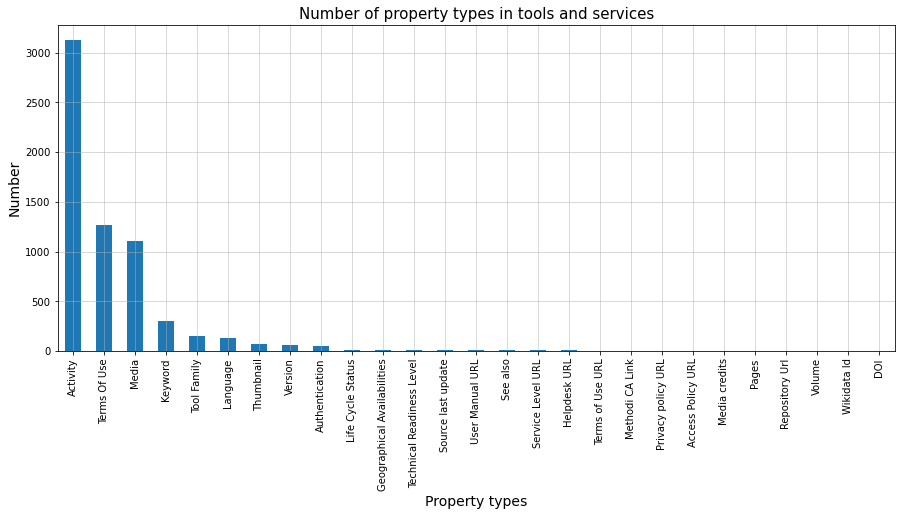

In [125]:
df_temp_type_label = df_prop_data['type.label'].value_counts()
fig, ax = plt.subplots()
df_temp_type_label.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of property types in tools and services", fontsize=15)
ax.set_xlabel('Property types', fontsize=14)
ax.set_ylabel('Number', fontsize=14);
plt.show()

## Publications

In [ ]:
df_pub_all = pd.DataFrame()
df_pub_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/publications?page=", 151)
df_pub_all.index

#### Overview of the values in properties for publications

In [271]:
df_prop__pub_data = pd.json_normalize(data=df_pub_all['publications'], record_path='properties', meta=['label'])
#df_prop__pub_data.tail()

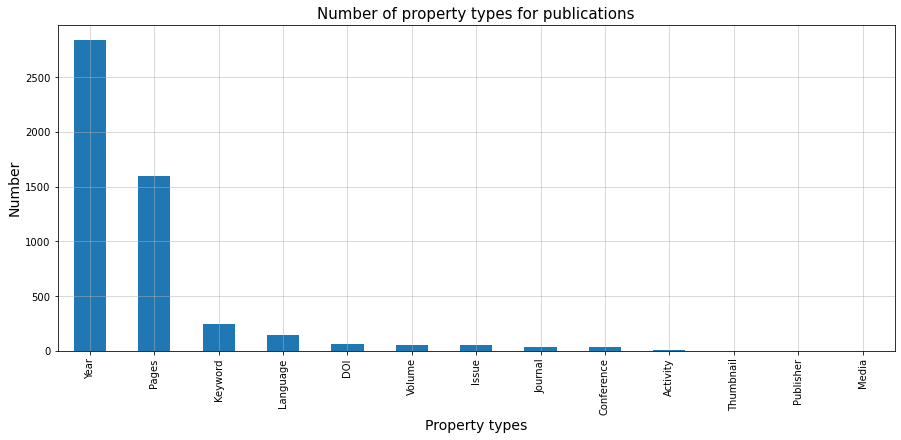

In [272]:
df_temp_pub_type_label = df_prop__pub_data['type.label'].value_counts()
fig, ax = plt.subplots()
df_temp_pub_type_label.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of property types for publications", fontsize=15)
ax.set_xlabel('Property types', fontsize=14)
ax.set_ylabel('Number', fontsize=14);
plt.show()

## Training Materials

In [20]:
#https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/training-materials

tmx = pd.Series(range(1,8))
#url = 'https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/publications?page=1&perpage=20'
df_tm_all = pd.DataFrame()
for var in tmx:
    url = "https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/training-materials?page="+str(var)+"&perpage=20"
    df_tm_par=pd.read_json(url, orient='columns')
    df_tm_all=df_tm_all.append(df_tm_par, ignore_index=True)
   # print("url: "+ url + ":",var)
df_tm_all.index

RangeIndex(start=0, stop=140, step=1)

#### Overview of the values in properties for Training Materials

In [22]:
df_prop__tm_data = pd.json_normalize(data=df_tm_all['trainingMaterials'], record_path='properties', meta=['label'])
#df_prop__tm_data.head()

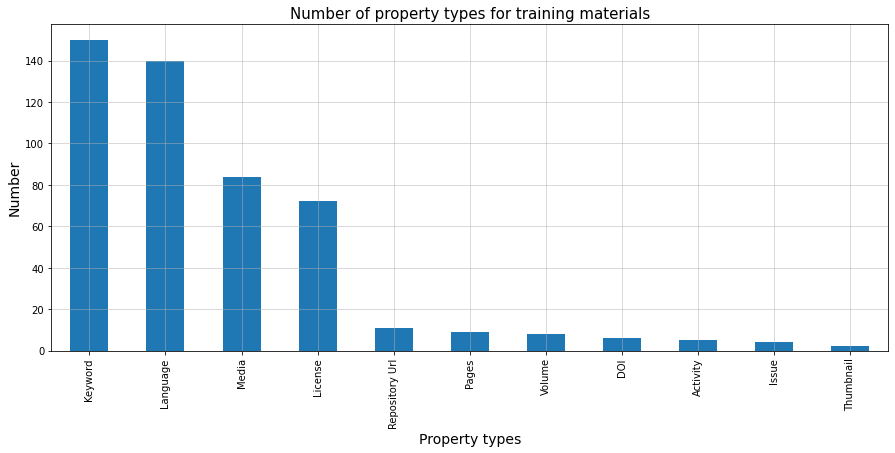

In [24]:
df_temp_tm_type_label = df_prop__tm_data['type.label'].value_counts()
fig, ax = plt.subplots()
df_temp_tm_type_label.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of property types for training materials", fontsize=15)
ax.set_xlabel('Property types', fontsize=14)
ax.set_ylabel('Number', fontsize=14);
plt.show()

## Workflows

In [273]:
df_wf_all = pd.DataFrame()
df_wf_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/workflows?page=", 2)
df_wf_all.index

RangeIndex(start=0, stop=29, step=1)

#### Overview of the values in properties in Workflows

In [274]:
df_prop__wf_data = pd.json_normalize(data=df_wf_all['workflows'], record_path='properties', meta=['label'])
#df_prop__wf_data.head()

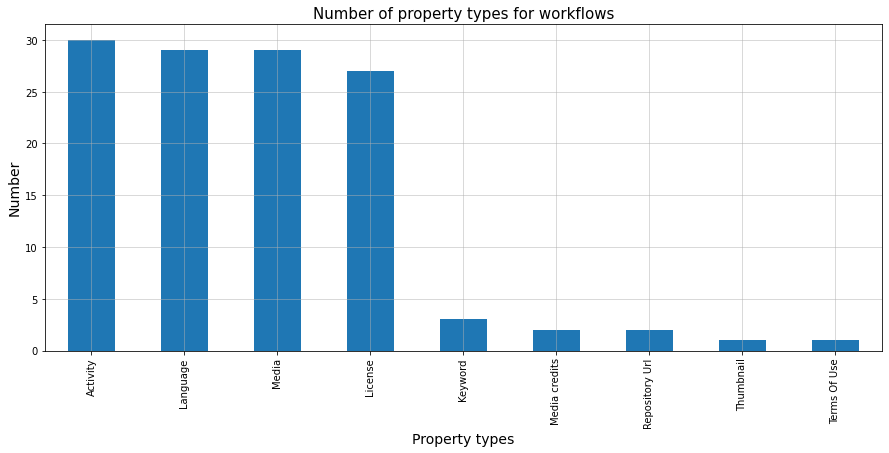

In [275]:
df_temp_wf_type_label = df_prop__wf_data['type.label'].value_counts()
fig, ax = plt.subplots()
df_temp_wf_type_label.plot(kind='bar', figsize=(15,6), x='licences', y='tools',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of property types for workflows", fontsize=15)
ax.set_xlabel('Property types', fontsize=14)
ax.set_ylabel('Number', fontsize=14);
plt.show()

### Check properties in the complete dataset

In [67]:
df_list=[df_prop_data, df_prop__pub_data, df_prop__tm_data, df_prop__wf_data]
df_all_data=pd.concat(df_list)
#df_all_data.sort_values('type.code').iloc[7550:7590]

Gets all the TaDiRAH2 propertiess

In [278]:
tad_prop=df_all_data[df_all_data['concept.vocabulary.code'] == 'tadirah2']
tad_prop.head(2)

,id,value,type.code,type.label,type.type,type.ord,type.allowedVocabularies,concept.code,concept.vocabulary.code,concept.vocabulary.label,concept.vocabulary.accessibleAt,concept.label,concept.notation,concept.definition,concept.uri,concept,label
0,183640,None,activity,Activity,concept,2,"[{'code': 'nemo-activity-type', 'label': 'NeMO Concept Scheme', 'accessibleAt': None}, {'code': 'tadirah2', 'label': '', 'accessibleAt': None}, {'code': 'tadirah-activity', 'label': 'TaDiRAH - Tax...",https://vocabs.dariah.eu/tadirah/capturing,tadirah2,,NaN,Capturing,,,https://vocabs.dariah.eu/tadirah/capturing,NaN,140kit
1,183641,None,activity,Activity,concept,2,"[{'code': 'nemo-activity-type', 'label': 'NeMO Concept Scheme', 'accessibleAt': None}, {'code': 'tadirah2', 'label': '', 'accessibleAt': None}, {'code': 'tadirah-activity', 'label': 'TaDiRAH - Tax...",https://vocabs.dariah.eu/tadirah/gathering,tadirah2,,NaN,Gathering,,,https://vocabs.dariah.eu/tadirah/gathering,NaN,140kit


In [41]:
df_temp_tad_label = tad_prop['concept.label'].value_counts()
df_temp_tad_label.head(15)

Analyzing           576
Visual Analysis     303
Content Analysis    226
Discovering         171
Capturing           150
Enriching           121
Gathering           116
Disseminating       112
Annotating          112
Publishing           87
Collaborating        87
Creating             85
Sharing              84
Organizing           81
Network Analysis     77
Name: concept.label, dtype: int64

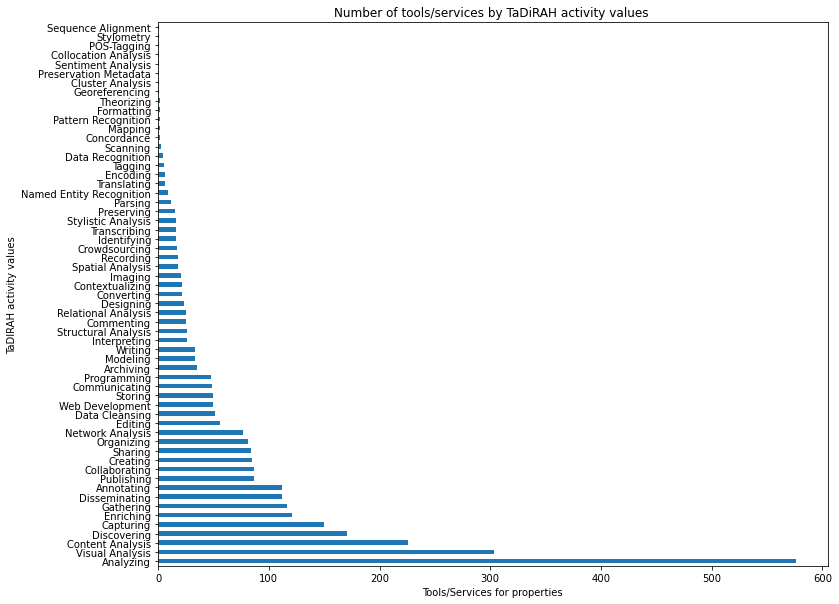

In [42]:
fig, ax = plt.subplots()
df_temp_tad_label.plot.barh(figsize=(12,10), ax=ax)
ax.set_title('Number of tools/services by TaDiRAH activity values ')
ax.set_xlabel('Tools/Services for properties')
ax.set_ylabel('TaDIRAH activity values');

In [44]:
act_prop_temp=tad_prop[['type.label', 'value', 'type.code', 'type.type', 'concept.label', 'concept.uri', 'concept.vocabulary.code', 'concept.vocabulary.label']]
act_prop=act_prop_temp.drop_duplicates()
act_prop.head()

,type.label,value,type.code,type.type,concept.label,concept.uri,concept.vocabulary.code,concept.vocabulary.label
0,Activity,None,activity,concept,Capturing,https://vocabs.dariah.eu/tadirah/capturing,tadirah2,
1,Activity,None,activity,concept,Gathering,https://vocabs.dariah.eu/tadirah/gathering,tadirah2,
2,Activity,None,activity,concept,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing,tadirah2,
3,Activity,None,activity,concept,Visual Analysis,https://vocabs.dariah.eu/tadirah/visualAnalysis,tadirah2,
26,Activity,None,activity,concept,Web Development,https://vocabs.dariah.eu/tadirah/webDevelopment,tadirah2,


In [50]:
act_prop.sort_values('concept.label').to_csv(path_or_buf='/Users/cesare/Documents/sshoc/wp7/actualtadirahvalues.csv')

See the [list of properties](https://docs.google.com/spreadsheets/d/1RumPVwXA4SSzheaKs6r0ymR41d8VsbMbG-19edAzd58/edit?usp=sharing) in a google sheet

### Finding items having duplicated TaDiRAH activities

In [49]:
df_p_d=tad_prop[tad_prop.duplicated(['label', 'concept.label'], keep=False)].sort_values('label')
#df_p_d.tail(2)

In [105]:
act_prop_temp_dupl=df_p_d[['label', 'concept.label', 'concept.uri','type.label', 'value', 'type.code', 'type.type', 'concept.vocabulary.code', 'concept.vocabulary.label']]
act_prop_temp_dupl.sort_values(['label','concept.label']).head(8)

,label,concept.label,concept.uri,type.label,value,type.code,type.type,concept.vocabulary.code,concept.vocabulary.label
14,Collaborative Digital Edition of a Musical Corpus,Formatting,https://vocabs.dariah.eu/tadirah/formatting,Activity,None,activity,concept,tadirah2,
12,Collaborative Digital Edition of a Musical Corpus,Formatting,https://vocabs.dariah.eu/tadirah/formatting,Activity,None,activity,concept,tadirah2,
1098,Cytoscape,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing,Activity,None,activity,concept,tadirah2,
1103,Cytoscape,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing,Activity,None,activity,concept,tadirah2,
1104,Cytoscape,Visual Analysis,https://vocabs.dariah.eu/tadirah/visualAnalysis,Activity,None,activity,concept,tadirah2,
1099,Cytoscape,Visual Analysis,https://vocabs.dariah.eu/tadirah/visualAnalysis,Activity,None,activity,concept,tadirah2,
1149,Data Desk,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing,Activity,None,activity,concept,tadirah2,
1154,Data Desk,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing,Activity,None,activity,concept,tadirah2,


In [51]:
act_prop_temp_dupl.sort_values('label').to_csv(path_or_buf='/Users/cesare/Documents/sshoc/wp7/duplicatetadirahvalues.csv')

## Inspecting *contributors* property for Tools and Services

In [284]:
df_prop_data = pd.json_normalize(data=df_tool_all['tools'], record_path='contributors', meta_prefix='tool_', meta=['label'])
df_prop_data.sort_values('tool_label').tail()

,actor.id,actor.name,actor.externalIds,actor.website,actor.email,actor.affiliations,role.code,role.label,tool_label
1333,546,Jason Davies,[],http://www.jasondavies.com/,None,[],contributor,Contributor,word tree
1316,794,word2vec Team,[],http://code.google.com/p/word2vec/,None,[],contributor,Contributor,word2vec
1329,704,iamsqrt1,[],https://code.google.com/u/iamsqrt1@gmail.com/,None,[],contributor,Contributor,wordsimilarity (Word 2 Word)
1348,896,"Centre for Computing in the Humanities, King's College London",[],http://www.tei-c.org/Vault/MembersMeetings/2008/xmod/index.html,None,[],contributor,Contributor,xMod
1355,950,yWorks,[],None,None,[],contributor,Contributor,yED Files


In [287]:
df_prop_data['actor.name'].value_counts().head()

Geoffrey Rockwell et. al.                50
Stéfan Sinclair and Geoffrey Rockwell    22
Tomasz Walkowiak                         19
Clarin-PL                                19
Ambrosia Software Inc.                   18
Name: actor.name, dtype: int64

In [299]:
df_prop_data.count()

actor.id              1372
actor.name            1372
actor.externalIds     1372
actor.website          566
actor.email            293
actor.affiliations    1372
role.code             1372
role.label            1372
tool_label            1372
dtype: int64

As for the *accessibleAt*, validity of *actor.wbsite* value could be checked etc....

## More...

In [412]:
tad_prop_cd_work=tad_prop[['id', 'concept.vocabulary.code','label', 'concept.label', 'concept.uri']]
tad_prop_cd_work.count()

id                         3162
concept.vocabulary.code    3162
label                      3162
concept.label              3162
concept.uri                3162
dtype: int64

In [414]:
dupl_prop=tad_prop_cd_work[tad_prop_cd_work.duplicated(['label','concept.label'], keep='last')]
dupl_prop.head().sort_values(['label', 'concept.label'])

,id,concept.vocabulary.code,label,concept.label,concept.uri
1098,179016,tadirah2,Cytoscape,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing
1099,179017,tadirah2,Cytoscape,Visual Analysis,https://vocabs.dariah.eu/tadirah/visualAnalysis
1149,181970,tadirah2,Data Desk,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing
1150,181971,tadirah2,Data Desk,Visual Analysis,https://vocabs.dariah.eu/tadirah/visualAnalysis
1274,182540,tadirah2,DfR Browser,Analyzing,https://vocabs.dariah.eu/tadirah/analyzing


In [415]:
dupl_prop.count()

id                         18
concept.vocabulary.code    18
label                      18
concept.label              18
concept.uri                18
dtype: int64

In [411]:
cleaned_prop=tad_prop_cd_work.drop_duplicates(['label','concept.label'])
cleaned_prop.count()

id                         3144
concept.vocabulary.code    3144
label                      3144
concept.label              3144
concept.uri                3144
dtype: int64

In [418]:
test_prop=cleaned_prop.groupby('label')['concept.label'].apply(list).reset_index(name='properties')
test_prop.sort_values('label').head()

,label,properties
0,"""On the record"" - transcribing and valorizing qualitative interviews with XML-TEI","[Transcribing, Encoding, Annotating]"
1,140kit,"[Capturing, Gathering, Analyzing, Visual Analysis]"
2,4th Dimension,"[Web Development, Programming, Writing]"
3,80legs,"[Discovering, Analyzing]"
4,960 Grid System,"[Creating, Web Development]"


In [419]:
properties_counter = Counter(itertools.chain(*test_prop['properties']))
print('There are {} unique properties in the MP dataset.'.format(len(properties_counter)))

There are 59 unique properties in the MP dataset.


In [467]:
print("Top properties by Frequency", '\n')
print('{:<40}Frequency'.format("Property"))
for k, v in properties_counter.most_common(10):
    print(f'{k:<40}{v}')

Top properties by Frequency 

Property                                Frequency
Analyzing                               567
Visual Analysis                         300
Content Analysis                        225
Discovering                             171
Capturing                               150
Enriching                               121
Gathering                               116
Annotating                              112
Disseminating                           111
Publishing                              87


In [468]:
#print('\nMedian Property Freqency:')
#print(np.median(list(properties_counter.values())))

In [422]:
cooccurrences = []

for props in test_prop['properties']:
    prop_pairs = itertools.combinations(props, 2)
    for pair in prop_pairs:
        cooccurrences.append(tuple(sorted(pair)))

# Count the frequency of each cooccurring pair.
properties_co_counter = Counter(cooccurrences)

In [426]:
print("Top Properties Cooccurrences by Frequency", '\n')
print('{:<70}{}'.format('Cooccurrence', 'Frequency'))
for k, v in properties_co_counter.most_common(10):
    topics = k[0] + ' +++ ' + k[1]
    print(f'{topics:<70}{v}')
    
print('\nMedian Property Cooccurrence Freqency:')
print(np.median(list(properties_co_counter.values())))

Top Properties Cooccurrences by Frequency 

Cooccurrence                                                          Frequency
Analyzing +++ Visual Analysis                                         247
Analyzing +++ Content Analysis                                        214
Analyzing +++ Discovering                                             114
Capturing +++ Gathering                                               91
Analyzing +++ Capturing                                               66
Analyzing +++ Network Analysis                                        64
Annotating +++ Enriching                                              58
Analyzing +++ Gathering                                               54
Collaborating +++ Disseminating                                       53
Discovering +++ Visual Analysis                                       52

Median Property Cooccurrence Freqency:
4.0


In [445]:
property_cooccurrences = list(
    itertools.chain(*[[tuple(sorted(c)) for c in itertools.combinations(d, 2)] 
                      for d in test_prop['properties']])
)
# Count the frequency of each cooccurring pair.
property_edge_counter = Counter(property_cooccurrences)

In [446]:
property_cooccurrence_df = pd.DataFrame({
    'prop0': [dcc[0] for dcc in property_edge_counter.keys()],
    'prop1': [dcc[1] for dcc in property_edge_counter.keys()],
    'count': list(property_edge_counter.values()),
}).pivot_table(index='prop0', columns='prop1')['count']

In [447]:
import seaborn as sns

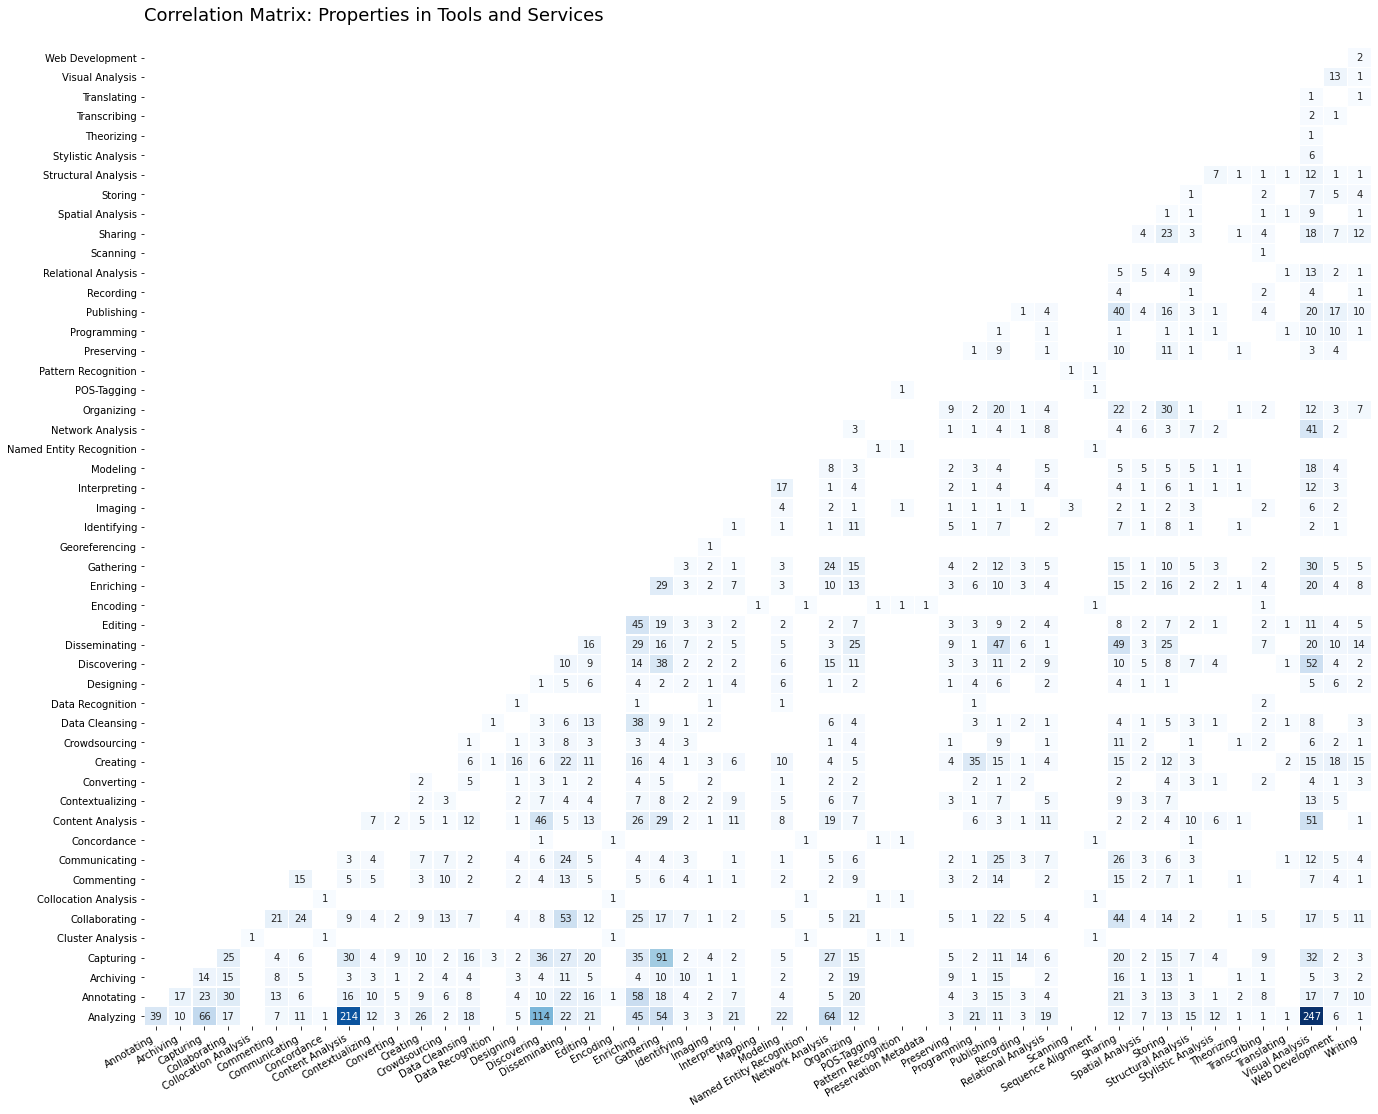

In [464]:
fig, ax = plt.subplots(figsize=(22, 18))
sns.heatmap(property_cooccurrence_df, annot=True, linewidth=0.5, fmt='.0f', ax=ax, cbar=None, cmap='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#ax.set_title('Property cooccurences in Tools and Services')
title = 'Correlation Matrix: Properties in Tools and Services\n'
plt.title(title, loc='left', fontsize=18)
plt.show()